# <span style="color:orange"> Exercise 12.2 </span>

## <span style="color:green"> Task </span>
Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**<br><br>
The cell below shows some information about the dataset, such as the size and a set of 10 images to reveal the appearance of the data.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


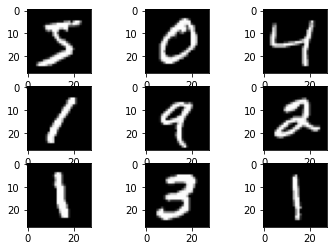

In [22]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from keras.datasets import mnist
from matplotlib import pyplot as plt
from numba import jit, njit
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### Preparing Data

The following functions respectively load the MNIST dataset and scale the pixels of the images. In fact, the images are made up of pixels whose values are integers describing a color between black and white, or an integer from 0 to 255. Therefore, the second function normalizes the values of the pixels to the range [0,1] after having converted them to floats.

In [23]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print(len(trainX),"-",len(trainY),"-",len(testX),"-",len(testY))
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

### Defining model
The model that I used to define the convolutional neural network starts with a Convolutional Layer with a moderate amount of filters (32) and a filter size of (3,3). The layer is followed by a Max Pooling Layer, while the filter map is then flattened using a Flatten layer.
The output layer should consist of 10 nodes because the images must be classified across 10 different classes, while the same layer should follow the softmax activation function. The softmax activation function $\sigma : {\rm I\!R}^K \longrightarrow [0,1]^K$ is defined by: $$ \sigma(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K}e^{z_j}}, $$
used to normalize the output of a neural network to a probability distribution. Between the convolutional layers and the output layer, I introduced a dense layer with 100 neurons and a ReLU activation function. <br>
The model uses a Stochastic Descent Gradient (SDG) optimizer with a learning rate of 0.01 and a momentum of 0.9, a categorical cross-entropy loss function and will monitor the classification accuracy metric.

In [24]:
# define CNN model
def define_model(summarize:bool=False,save:bool=False):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    if summarize:
        model.summary()
    if save:
        from pathlib import Path
        dir = "./models/"
        Path(dir).mkdir(parents=True, exist_ok=True)
        print("[MODEL] Saved model to directory: "+dir)
        model.save(dir)
    return model

#### Using a 5-fold validation
<img src="../media/images/kfold-validation.png" alt="Five-fold cross validation" width="800" height="600">
<br>The model will be evaluated using a five-fold cross validation. In general, a k-fold cross validation is used to effectively split a small part of the full dataset for testing purposes, while the rest is used for training purposes. The K-fold cross validation splits the dataset into K partitions of equal size, so that K-1 can be used for training while the last one can be used for testing. Finally, the procedure is repeated K times, with a different partition for each iteration. In the case of a five-fold cross validation, the dataset is split into 80/20, each time with a different portion used for testing. <br>
The model is trained with a standard batch size of 32 examples and with 10 epochs. The latter is lower than usual, primarily because the five-fold validation process requires five times for computational power than manual validation, while the number is still valid for accurate results. 

In [25]:
# evaluate a model using k-fold cross-validation

def evaluate_model(dataX, dataY, n_folds=5, model=None):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    iter = 0
    
    for train_ix, test_ix in kfold.split(dataX):
        print("[EVAL] Running iteration {}".format(iter))
        # define model
        if model is None:
            if iter<n_folds-1:
                model = define_model(save=False)
            else:
                model = define_model(save=True)
        else:
            model = model
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
        iter += 1
    return scores, histories

###  Validation
The evaluation method defined in the previous cell returns a list of accuracy scores and training histories used to summarize and validate the model. The diagnostics function aims to plot the model performance for training and testing during each fold of the five-fold cross-validation, for both the loss and the accuracy of the model. The performance is then summarized by calculated the mean and standard deviation of the accuracy scores.

In [1]:
# plot diagnostic learning curves ---> training
def summarize_diagnostics(histories):
    fig, ax = plt.subplots(2,1, gridspec_kw={'hspace': 0.6})
    for i in range(len(histories)):
        ax[0].set_title('Cross Entropy Loss')
        ax[0].plot(histories[i].history['loss'], color='blue', label='train')
        ax[0].plot(histories[i].history['val_loss'], color='orange', label='test')
        ax[0].set_xlabel("Epoch")
        ax[0].set_xlabel("Loss")
        # plot accuracy
        ax[1].set_title('Classification Accuracy')
        ax[1].plot(histories[i].history['accuracy'], color='blue', label='train')
        ax[1].plot(histories[i].history['val_accuracy'], color='orange', label='test')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
    pyplot.show()
 
# summarize model performance ---> testing
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores) 
    plt.ylabel("Accuracy")
    plt.show()
 
# run the test harness for evaluating a model
def run(model=None):
    # load dataset
    print("\r[RUN] Loading dataset..")
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    print("\r[RUN] Preparing pixels")
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    print("\r[RUN] Creating and evaluating the model")
    scores, histories = evaluate_model(trainX, trainY, model=model)
    # learning curves
    print("\r[RUN] Learning curves")
    summarize_diagnostics(histories)
    # summarize estimated performance
    print("\r[RUN] Evaluating performance")
    summarize_performance(scores)

[RUN] Loading dataset..
60000 - 60000 - 10000 - 10000
[RUN] Preparing pixels
[RUN] Creating and evaluating the model
[EVAL] Running iteration 0
> 98.600
[EVAL] Running iteration 1
> 99.842
[EVAL] Running iteration 2
> 99.992
[EVAL] Running iteration 3
> 100.000
[EVAL] Running iteration 4
> 100.000
[RUN] Learning curves


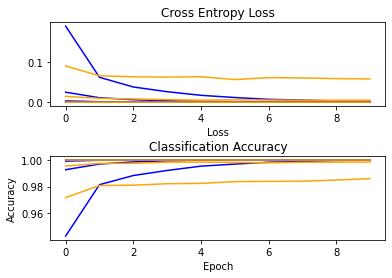

[RUN] Evaluating performance
Accuracy: mean=99.687 std=0.547, n=5


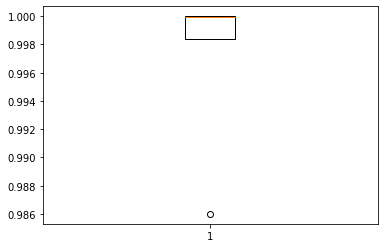

In [45]:
run()

## <span style="color:green"> Results </span>
When running the CNN, each fold of the cross-validation produces an excellent accuracy score, which means that the network is classifying the images very well. The plots show how the model is learning during each fold, where both <span style="color:blue"> training </span> and <span style="color:orange"> testing </span> curves converge, meaning that the data is not being over-fitted or under-fitted.<br>
To summarize the model performance, the model has an estimated accuracy of 98.7\%, which is a good result. This is also shown in a box and whisker plot, which exposes quantities like the maximum value, the minimum value, the median, the first and third quartile of the data.<br>

## <span style="color:green"> How to improve the model </span>
The following section explores how the CNN model could be improved to correctly predict and classify images.

### Learning rate
Probably, the most impactful variable is the learning rate of the Stochastic Descent Gradient, which is the hyperparameter that defines the rate at which the weights of the model are updated during training. It is a difficult task to find a good balance for its value, since a value that is too large can cause the model to converge too quickly to an inaccurate solution, while a value that is too low can cause the model to get stuck or take very long times to converge.

### Batch Normalization
Batch normaization is a process to standardize the inputs to a layer in a Neural Network. This can accelerate the learning pace of a model and sometimes improve its accuracy. The Batch Normalization layer is typically introduced after convolutional and fully-connected layers, to standardize inputs so that the mean is zero and the standard deviation is one. Finally, the standardized outputs can be eventually scaled to extract the new mean and standard deviation for the final output.<br>
For this specific CNN model, I've decided to introduce the Batch Normalization layer after the activation function, between the convolutional and the max pooling layers:<br>

In [46]:
from keras.layers import BatchNormalization
# define CNN model
def define_model(summarize:bool=False,save:bool=False):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate =0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    if summarize:
        model.summary()
    if save:
        from pathlib import Path
        dir = "./models/"
        Path(dir).mkdir(parents=True, exist_ok=True)
        print("[MODEL] Saved model to directory: "+dir)
        model.save(dir)
    return model

[RUN] Loading dataset..
60000 - 60000 - 10000 - 10000
[RUN] Preparing pixels
[RUN] Creating and evaluating the model
[EVAL] Running iteration 0
> 98.575
[EVAL] Running iteration 1
> 99.783
[EVAL] Running iteration 2
> 100.000
[EVAL] Running iteration 3
> 100.000
[EVAL] Running iteration 4
> 100.000
[RUN] Learning curves


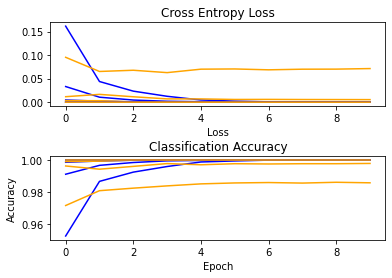

[RUN] Evaluating performance
Accuracy: mean=99.672 std=0.555, n=5


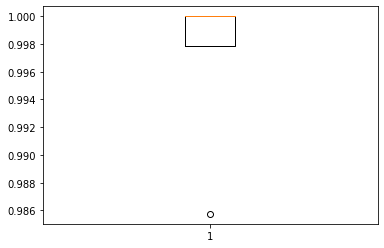

In [47]:
run()